In [2]:
import jax
import jax.numpy as jnp
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import optax
sns.set_style("darkgrid")

In [3]:
points = 1000
key = jax.random.PRNGKey(seed=42)

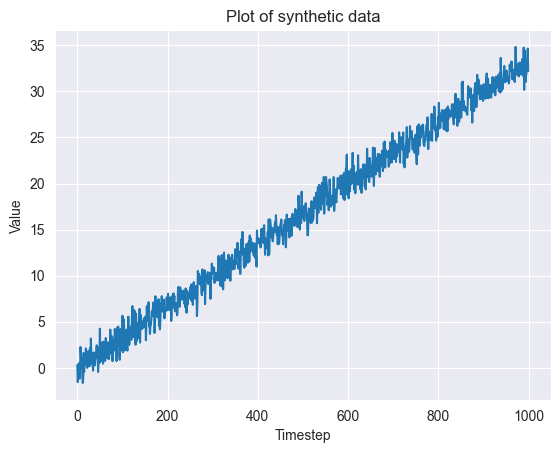

In [4]:
data = jnp.arange(0, points) * 1/30 + jax.random.normal(key=key, shape=(points,))
sns.lineplot(data)
plt.title("Plot of synthetic data")
plt.xlabel("Timestep")
plt.ylabel("Value")
plt.show();

In [5]:
from lstm import LSTM
from pprint import pprint

In [6]:
archi_params, params = LSTM.init_params(seed=42, input_dim=1, hidden_dim=1, output_dim=1)

In [49]:
import pickle

In [50]:
with open("somefile.pkl", "wb") as f:
    pickle.dump(params._asdict(), f)

In [52]:
with open("somefile.pkl", "rb") as f:
    reading = pickle.load(f)

In [7]:
zero_arr = jnp.array([[0.]])

In [8]:
params.wf

Array([[-0.18471177]], dtype=float32)

In [9]:
jnp.concatenate([zero_arr, zero_arr], axis=1)

Array([[0., 0.]], dtype=float32)

In [10]:
LSTM.f_cur(params, zero_arr, zero_arr)

Array([[0.4539529]], dtype=float32)

In [11]:
LSTM.i_cur(params, zero_arr, zero_arr)

Array([[0.4539529]], dtype=float32)

In [12]:
LSTM.c_cur(params, zero_arr, zero_arr, zero_arr)

Array([[-0.08290966]], dtype=float32)

In [13]:
LSTM.h_cur(params, zero_arr, zero_arr, zero_arr)

(Array([[-0.03755108]], dtype=float32), Array([[-0.08290966]], dtype=float32))

In [14]:
print(jnp.array([[0.]])[:,0])

[0.]


In [15]:
def preprocess_ts(
    x: jnp.ndarray, 
    y: jnp.ndarray,
    timestep: int
) -> tuple[jnp.ndarray, jnp.ndarray]:
    x_window = np.lib.stride_tricks.sliding_window_view(
        x, window_shape=(timestep,), axis=0
    )
    y_window = np.lib.stride_tricks.sliding_window_view(
        y, window_shape=(timestep,), axis=0
    )

    x_window = jnp.expand_dims(x_window, axis=(1, 3, 4))
    y_window = jnp.expand_dims(jnp.expand_dims(jnp.array(y_window), axis=2), axis=(3, 4))
    return jnp.array(x_window), jnp.array(y_window)

In [16]:
x_window, y_window = preprocess_ts(data, data[1:], 5)

Each input will be a 2D array, with each 1D array inside it containing the time series for one variate.

In [17]:
x_window

Array([[[[[ 0.29209465]],

         [[-1.5557797 ]],

         [[-0.8518964 ]],

         [[ 0.44845632]],

         [[ 0.43506557]]]],



       [[[[-1.5557797 ]],

         [[-0.8518964 ]],

         [[ 0.44845632]],

         [[ 0.43506557]],

         [[ 0.5150125 ]]]],



       [[[[-0.8518964 ]],

         [[ 0.44845632]],

         [[ 0.43506557]],

         [[ 0.5150125 ]],

         [[-1.1798042 ]]]],



       ...,



       [[[[31.017595  ]],

         [[31.68528   ]],

         [[31.953054  ]],

         [[33.162685  ]],

         [[33.64185   ]]]],



       [[[[31.68528   ]],

         [[31.953054  ]],

         [[33.162685  ]],

         [[33.64185   ]],

         [[34.651623  ]]]],



       [[[[31.953054  ]],

         [[33.162685  ]],

         [[33.64185   ]],

         [[34.651623  ]],

         [[32.186543  ]]]]], dtype=float32)

In [18]:
y_window

Array([[[[[-1.5557797 ]]],


        [[[-0.8518964 ]]],


        [[[ 0.44845632]]],


        [[[ 0.43506557]]],


        [[[ 0.5150125 ]]]],



       [[[[-0.8518964 ]]],


        [[[ 0.44845632]]],


        [[[ 0.43506557]]],


        [[[ 0.5150125 ]]],


        [[[-1.1798042 ]]]],



       [[[[ 0.44845632]]],


        [[[ 0.43506557]]],


        [[[ 0.5150125 ]]],


        [[[-1.1798042 ]]],


        [[[ 2.2500584 ]]]],



       ...,



       [[[[31.017595  ]]],


        [[[31.68528   ]]],


        [[[31.953054  ]]],


        [[[33.162685  ]]],


        [[[33.64185   ]]]],



       [[[[31.68528   ]]],


        [[[31.953054  ]]],


        [[[33.162685  ]]],


        [[[33.64185   ]]],


        [[[34.651623  ]]]],



       [[[[31.953054  ]]],


        [[[33.162685  ]]],


        [[[33.64185   ]]],


        [[[34.651623  ]]],


        [[[32.186543  ]]]]], dtype=float32)

In [19]:
archi_params, params = LSTM.init_params(seed=42, input_dim=1, hidden_dim=40, output_dim=1)

In [20]:
from lstm import sigmoid

In [21]:
forward_full_batch = jax.vmap(LSTM.forward_full, in_axes=(None, 0))

In [22]:
x_window[0:2]

Array([[[[[ 0.29209465]],

         [[-1.5557797 ]],

         [[-0.8518964 ]],

         [[ 0.44845632]],

         [[ 0.43506557]]]],



       [[[[-1.5557797 ]],

         [[-0.8518964 ]],

         [[ 0.44845632]],

         [[ 0.43506557]],

         [[ 0.5150125 ]]]]], dtype=float32)

In [23]:
x_window[0][0]

Array([[[ 0.29209465]],

       [[-1.5557797 ]],

       [[-0.8518964 ]],

       [[ 0.44845632]],

       [[ 0.43506557]]], dtype=float32)

In [24]:
print(x_window[0].shape)

(1, 5, 1, 1)


In [25]:
h, c = jnp.zeros(shape=(archi_params.hidden_dim, 1)), jnp.zeros(shape=(archi_params.hidden_dim, 1))
(params, h, c), o_ls = jax.lax.scan(LSTM.forward, (params, h, c), x_window[0][0])

In [26]:
mapped = jax.vmap(LSTM.forward_full, in_axes=(None, None, 0))

In [27]:
mapped(archi_params, params, x_window[0:1])

Array([[[[10.111839]],

        [[ 3.015719]],

        [[ 8.144914]],

        [[12.445827]],

        [[13.568062]]]], dtype=float32)

In [28]:
out = LSTM.forward_batch(archi_params, params, x_window[100:110])
out

Array([[[14.826654 ],
        [15.145139 ],
        [15.902785 ],
        [16.553047 ],
        [16.3469   ]],

       [[13.309992 ],
        [16.024593 ],
        [16.531994 ],
        [16.316366 ],
        [14.69013  ]],

       [[14.569132 ],
        [16.711246 ],
        [16.421726 ],
        [14.52302  ],
        [16.176401 ]],

       [[14.780206 ],
        [16.1729   ],
        [14.5824795],
        [15.911734 ],
        [15.032288 ]],

       [[14.509839 ],
        [15.452095 ],
        [15.600626 ],
        [14.874721 ],
        [15.821944 ]],

       [[13.513748 ],
        [15.882512 ],
        [14.984436 ],
        [15.540826 ],
        [16.417252 ]],

       [[14.450835 ],
        [15.652191 ],
        [15.391778 ],
        [16.258226 ],
        [15.19788  ]],

       [[13.871764 ],
        [15.766208 ],
        [16.103706 ],
        [14.979617 ],
        [14.48372  ]],

       [[14.276126 ],
        [16.154024 ],
        [15.055746 ],
        [14.322727 ],
        [16.1784

In [29]:
true = y_window[0:2]
true

Array([[[[[-1.5557797 ]]],


        [[[-0.8518964 ]]],


        [[[ 0.44845632]]],


        [[[ 0.43506557]]],


        [[[ 0.5150125 ]]]],



       [[[[-0.8518964 ]]],


        [[[ 0.44845632]]],


        [[[ 0.43506557]]],


        [[[ 0.5150125 ]]],


        [[[-1.1798042 ]]]]], dtype=float32)

In [30]:
num_epochs = 10
batch_size = 3
num_batches = x_window.shape[0] // batch_size
learning_rate = 1e-3

In [31]:
params.wo.shape

(40, 1)

In [32]:
y_window[0:1]

Array([[[[[-1.5557797 ]]],


        [[[-0.8518964 ]]],


        [[[ 0.44845632]]],


        [[[ 0.43506557]]],


        [[[ 0.5150125 ]]]]], dtype=float32)

In [33]:
jnp.mean((LSTM.forward_batch(archi_params, params, x_window[0:1]) - y_window[0:1]) ** 2)

Array(107.91271, dtype=float32)

In [34]:
LSTM.mse(archi_params, params, x_window[100:110], y_window[100:110])

Array(149.52666, dtype=float32)

In [35]:
def sigmoid(x):
    return jnp.where(x >= 0, 1./(1. + jnp.exp(-x)), jnp.exp(x)/(1. + jnp.exp(x)))

In [36]:
mse_grad = jax.jacfwd(LSTM.mse, argnums=(1,))
mse_grad(archi_params, params, x_window[100:110], y_window[100:110])[0]

LSTMParams(wf=Array([[-6.91144168e-03],
       [ 1.09001147e-02],
       [ 6.31754939e-03],
       [ 1.94847155e-02],
       [ 1.01462565e-02],
       [ 1.23419166e-01],
       [ 8.36847246e-01],
       [ 1.99397400e-01],
       [ 2.45274841e-05],
       [ 6.06583834e-01],
       [ 4.07746172e+00],
       [ 4.56165314e-01],
       [ 3.84627783e-04],
       [-4.16516140e-02],
       [ 8.41244817e-01],
       [ 5.66210947e-04],
       [-7.24929338e-03],
       [ 9.20712893e-08],
       [-1.33645677e-04],
       [ 2.16135699e-02],
       [ 2.58968095e-04],
       [-3.54472036e-03],
       [ 2.00207300e-08],
       [-3.85844737e-01],
       [ 1.68680232e-02],
       [ 6.19905675e-03],
       [ 4.72210777e-05],
       [-9.26678069e-04],
       [ 4.30679368e-03],
       [-2.73737555e-06],
       [ 3.15071866e-02],
       [ 3.44300679e-06],
       [ 7.08751668e-10],
       [-4.03945774e-01],
       [ 3.92833375e-04],
       [ 1.66840231e+00],
       [-5.77749088e-02],
       [ 1.50405150e-03]

In [36]:
optimiser = optax.chain(
    optax.clip_by_global_norm(1.0),
    optax.adam(learning_rate=learning_rate)
)

opt_state = optimiser.init(params)

In [37]:
LSTM.mse(archi_params, params, x_window[0:10], y_window[0:10])

Array(132.26189, dtype=float32)

In [38]:
LSTM.backward(archi_params, params, x_window[500:510], y_window[500:510])

(LSTMParams(wf=Array([[-8.1461519e-02],
        [ 7.0429384e-04],
        [-6.4623415e-02],
        [ 6.2901717e-07],
        [ 2.5505935e-05],
        [ 4.0017188e-04],
        [ 2.7490972e-04],
        [ 1.4504837e-02],
        [ 1.0661230e-12],
        [ 6.8661612e-01],
        [ 2.4070864e-08],
        [ 1.5168284e-02],
        [ 1.8518988e-14],
        [-1.0285848e-04],
        [ 1.4066319e-03],
        [ 1.2236064e-12],
        [ 3.2068734e-04],
        [ 1.1189538e-34],
        [ 2.4432205e-07],
        [ 2.6155951e-07],
        [ 1.0863398e-10],
        [ 1.0569983e-06],
        [ 0.0000000e+00],
        [ 2.7812917e-16],
        [ 3.0819083e-10],
        [ 7.8781746e-16],
        [ 7.5522048e-06],
        [ 1.0963203e-01],
        [ 1.0956105e-10],
        [ 4.7876633e-12],
        [ 8.2879720e-10],
        [ 9.2241572e-30],
        [ 2.0431515e-34],
        [ 2.2433279e-03],
        [ 2.4944816e-08],
        [ 1.7559234e-04],
        [ 9.1670394e-02],
        [-5.8720279e-02]

In [41]:
results = LSTM.forward_batch(archi_params, params, x_window)

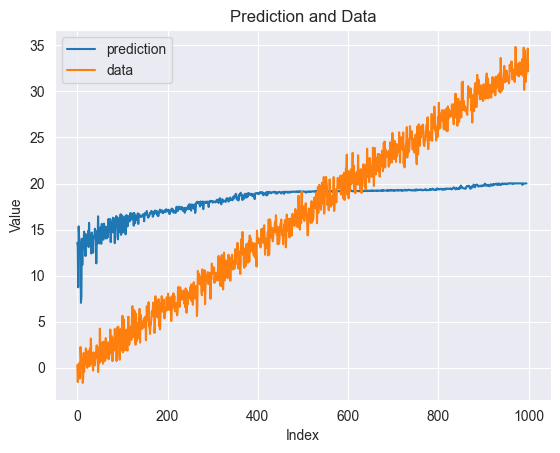

In [44]:
fig, ax = plt.subplots()
sns.lineplot(results[:,-1,-1], label="prediction", ax=ax)
sns.lineplot(data, label="data", ax=ax)
plt.xlabel("Index")
plt.ylabel("Value")
plt.title("Prediction and Data")
fig.savefig("pred_data_1")

In [40]:
params

LSTMParams(wf=Array([[ 0.05735137],
       [ 0.35336557],
       [-0.03811293],
       [ 0.7148857 ],
       [ 0.4676048 ],
       [-0.13748105],
       [ 0.694309  ],
       [ 0.708676  ],
       [-0.45364115],
       [ 0.20785907],
       [ 1.1753964 ],
       [ 0.15198867],
       [ 1.8448743 ],
       [-0.01743298],
       [ 0.5940068 ],
       [ 1.7478993 ],
       [ 0.14053968],
       [-1.6485916 ],
       [-0.03997775],
       [ 0.83717126],
       [ 1.1950213 ],
       [ 0.20102794],
       [-1.9391533 ],
       [-1.1340382 ],
       [ 1.3558896 ],
       [ 2.3079743 ],
       [ 0.05765337],
       [ 0.10294683],
       [ 1.3961357 ],
       [-0.3999834 ],
       [ 1.3211486 ],
       [-1.5606025 ],
       [-1.5751554 ],
       [ 0.15775731],
       [ 0.7066543 ],
       [ 0.5459628 ],
       [-0.3192952 ],
       [-0.2974074 ],
       [ 1.112433  ],
       [-0.43547055]], dtype=float32), uf=Array([[-0.66069317,  0.42994323,  0.06230739, ..., -0.2655144 ,
         0.13052358, 

In [41]:
for epoch in range(num_epochs):
    print(f"Epoch: {epoch + 1}")

    for i in range(num_batches):
        x_batch = x_window[i * batch_size : (i + 1) * batch_size]
        y_batch = y_window[i * batch_size : (i + 1) * batch_size]

        cur_grad = LSTM.backward(archi_params, params, x_batch, y_batch)[0]
        if (jnp.any(jnp.isnan(cur_grad.wf))):
            continue
        updates, opt_state = optimiser.update(cur_grad, opt_state, params)
        new_params = optax.apply_updates(params, updates)
        params = new_params

Epoch: 1
Epoch: 2
Epoch: 3
Epoch: 4


KeyboardInterrupt: 

In [42]:
results = LSTM.forward_batch(archi_params, params, x_window)

In [43]:
results.shape

(996, 5, 1)

In [44]:
params

LSTMParams(wf=Array([[-0.06854729],
       [ 0.35120964],
       [ 0.12984347],
       [ 0.4746134 ],
       [ 0.4068029 ],
       [ 0.04037511],
       [ 0.540245  ],
       [ 0.55772465],
       [-0.5417741 ],
       [ 0.18858857],
       [ 0.8812513 ],
       [ 0.1608685 ],
       [ 1.7784127 ],
       [ 0.07125598],
       [ 0.4817253 ],
       [ 1.7139454 ],
       [ 0.01306523],
       [-1.625622  ],
       [ 0.17180808],
       [ 0.47713652],
       [ 1.1681379 ],
       [ 0.0968767 ],
       [-1.9637454 ],
       [-0.8545227 ],
       [ 1.2309434 ],
       [ 2.1620634 ],
       [ 0.29663062],
       [ 0.24424477],
       [ 1.3378477 ],
       [-0.3119745 ],
       [ 0.95546126],
       [-1.5797851 ],
       [-1.5731277 ],
       [ 0.14314257],
       [ 0.67508554],
       [ 0.39701417],
       [-0.05965959],
       [-0.23421079],
       [ 1.0537168 ],
       [-0.32339844]], dtype=float32), uf=Array([[-0.4079765 ,  0.3470486 ,  0.23722047, ..., -0.17031768,
         0.04946145, 

In [45]:
results[:,-1,-1]

Array([ 2.3092935 ,  4.4715548 ,  0.3736133 ,  0.8408567 ,  2.9689472 ,
        1.4278058 ,  1.4262689 ,  2.8838463 ,  0.22957988, -0.05050169,
        1.7599275 ,  0.46128815,  3.495777  ,  0.82452184,  2.4577706 ,
        2.4293997 ,  2.4608614 ,  2.3705125 ,  2.800645  ,  2.22826   ,
        2.5756269 ,  3.3727667 ,  2.8909402 ,  2.9850242 ,  2.2993383 ,
        2.5296013 ,  3.3123655 ,  2.6628923 ,  3.736612  ,  2.6916542 ,
        2.849808  ,  2.863991  ,  1.7277412 ,  2.7777612 ,  2.4796846 ,
        2.3925712 ,  2.7226307 ,  2.5515866 ,  3.1077075 ,  3.5187082 ,
        3.3197358 ,  3.6517005 ,  1.7244003 ,  1.3369641 ,  3.2461057 ,
        2.5039768 ,  3.1456945 ,  2.1547074 ,  2.9937124 ,  1.9517368 ,
        3.1615593 ,  2.9821723 ,  3.439747  ,  3.1528003 ,  3.407833  ,
        3.4872627 ,  3.8704042 ,  2.726577  ,  3.0221121 ,  3.106018  ,
        3.398656  ,  3.962457  ,  3.3226933 ,  3.4534729 ,  3.2905753 ,
        2.8610284 ,  3.4709446 ,  2.6945918 ,  2.8193536 ,  3.73

In [1]:
sns.lineplot(results[:,-1,-1])
sns.lineplot(data)


NameError: name 'sns' is not defined